<a href="https://colab.research.google.com/github/itaewonflow/lecture-textmining-ml/blob/main/LDA_Gensim_Hangul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Itaewon flow github : https://github.com/itaewonflow
- Source Link : https://colab.research.google.com/github/itaewonflow/lecture-textmining-ml/blob/main/LDA_Gensim_Hangul.ipynb
- 마지막 작동 확인: 2023.11.16
---

## 0.사전설치: Konlpy 셋팅

In [96]:
# !curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash
!pip install konlpy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#1.Data Loding

- Openpyxl을 이용하여 데이타를 Pandas에 넣는다.

In [98]:
excel_file = './02. 크롤링 결과_우울글 채택된 답글만.xlsx'

In [99]:
import pandas as pd
from openpyxl import load_workbook

column_name = []
column_sentence = []
load_ws = load_workbook(excel_file, data_only=True)
sheet_name = load_ws.active
load_ws = load_ws[sheet_name.title]

check_line = 1
for row in load_ws.rows:
    rows_list = []
    for cell in row:
        rows_list.append(cell.value)

    if check_line == 1:
        column_name.append(rows_list)
    else:
        column_sentence.append(rows_list)
    check_line = check_line + 1

##2.Text preprocessing process
- 전처리는 OKT를 사용하여 명사형만을 사용하는 것으로 진행
- OKT 실행 후 1글자는 제외 처리
- CountVectorize를 사용하여 사용량이 적은 단어를 제외처리한다.
- sentences_list 변수는 LDA에 활용하기 위함
- sentences_list_word 변수는 Gensim에 활용하기 위함

In [100]:
from konlpy.tag import Okt
Okt = Okt()

In [101]:
sentences_list = []
sentences_list_word = []
for key, value in enumerate(column_sentence):
    temp_noun = Okt.nouns(value[1])
    temp_noun = [token for token in temp_noun if len(token) > 1]

    sentences_list.append(" ".join(temp_noun))
    sentences_list_word.append(temp_noun)

In [102]:
sentences_list[1]

'말씀 아내 우울증 아내 우울증 우울증 슬픔 눈물 우울 불안 분노 짜증 무기 의욕 희망 흥미 식욕 변화 수면 변화 신체 아픔 생각 이상 개월 이상 지속 심리 장애 학업 인간관계 전반 부정 영향 심지어 생각 듭니 우울증 치료 말씀 우울증 확진 일단 우울증 심리 장애 심리검사 면담 여러 우울증 병원 진단 아내 부정 영향 걱정 우울증 치료 스스로 꼬리표 붙이 말씀 또한 오진 가능성 문의 우울증 갑상선 것일 가능성 조울증 가능성 정신과 염두 심리검사 다른 검사 면담 진일 가능성 우울증 마음 감기 심리 장애 또한 우울증 진단 삭제 우울증 경우 누군가 무어 해도 말씀 또한 우울증 때문 보험 보험 회사 문의 말씀 보험 회사 보험 우울증 문제 또한 아내 두통 우울증 진단 우울증 신체 정도 라면 성화 아내 정신과 우울증 꼬리 걱정 심리상담 우울증 심리상담 만성 라면 우울증 심리상담 우울증 심리상담 우울증 치료 아내 우울증 좌절 용기 내세 우울증 심리상담 저희 우울증 심리상담 전국 우울증 심리상담 요즘 우울증 사람 생각 우울증 정신병 그냥 마음 웰빙 생각 마음 심리 도움 생각 생각 아내 우울증 스스로 아내 심리상담 아내 심리상담 생각 심리상담 소의 심리상담 심리상담 능력 인지도 블로그 홈페이지 가장 마음 우울증 심리상담 아내 분도 우울증 어려움 극복 실수 질문 도움 도움 기억 질문 답변 심리 상담 직접 차이 문의 사항 아래 참고'

In [119]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', max_features=2000, min_df=5, max_df=0.5)
sentences_cv = cv.fit_transform(sentences_list)

#3.LDA Loding

- max_iter를 8로 설정하면 알고리즘은 최대 8번의 반복을 수행합니다. 각 반복은 다음과 같은 단계로 구성됩니다:

- 초기화: 알고리즘은 토픽-단어 및 문서-토픽 분포를 초기화합니다. 이 초기화는 일반적으로 무작위로 이루어집니다.

- E 단계 (Expectation): 문서에 할당된 토픽을 바탕으로 각 단어의 토픽에 대한 기여도를 추정합니다. 이 단계에서는 단어의 토픽 기여도를 계산하기 위해 토픽-단어 및 문서-토픽 분포를 사용합니다.

- M 단계 (Maximization): E 단계에서 추정된 토픽 기여도를 바탕으로 토픽-단어 및 문서-토픽 분포를 업데이트합니다. 이 단계에서는 기여도를 최대화하는 방향으로 분포를 조정합니다.

- 수렴 확인: 알고리즘은 E 단계와 M 단계를 번갈아가며 수행하면서 반복적으로 토픽 분포를 업데이트합니다. 이때, max_iter 횟수만큼 반복을 수행하거나 더 이상 토픽 분포가 크게 변하지 않을 때까지 반복합니다.

In [104]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5,
                                topic_word_prior=0.1,
                                doc_topic_prior=1.0,
                                learning_method='online',
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

sentence_topics = lda.fit_transform(sentences_cv)

In [105]:
print('\n#shape of Topics:', sentence_topics.shape)
print('\n#Sample of Topics:', sentence_topics[0])
print('\n#Sample of Topics:', sentence_topics[1])

gross_topic_weights = np.mean(sentence_topics, axis=0)
print('\n#Sum of topic weights of documents:', gross_topic_weights)
print('\n#shape of topic word distribution:', lda.components_.shape)
print('\n#shape of topic word distribution:', lda.components_[0])


#shape of Topics: (1689, 10)

#Sample of Topics: [0.08384892 0.08333763 0.2102668  0.08393305 0.11445    0.08473273
 0.08333417 0.08564026 0.08664941 0.08380704]

#Sample of Topics: [0.34923029 0.03546192 0.05981301 0.02282314 0.0155061  0.01974699
 0.01425461 0.01446222 0.44868696 0.02001476]

#Sum of topic weights of documents: [0.14096101 0.09908885 0.0817008  0.08351592 0.12803315 0.10167149
 0.08261808 0.08087957 0.1219423  0.07958882]

#shape of topic word distribution: (10, 2000)

#shape of topic word distribution: [21.70967213 10.26330811  2.11263281 ...  0.12503997  0.10266915
  0.10236018]


### 결과해설
- Topics의 (2,10)의 의미는 행은 각 문서 그대로, 열의 값들은 LDA가 추출한 토픽의 비중
- 즉, LDA변환결과는 각 문서별로 토픽분포를 보여준다

- Topics의 첫째행을 출력하면 첫 문서의 각 토픽에 대한 분포를 볼 수 있다
- numpy로 열에 대해 총합을 구하면 문서 전체에 나타난 토픽의 평균 분포를 알 수 있다. 즉 말뭉치 전체에서는 3번째 토픽이 83.8%로 가장 많이 나타난다.

- lda.components_의 shape을 출력해보면 (10,17)이 나오는데, 이는 각 토픽에 대해 카운트 벡터에서 사용한 단어 2,000개의 비중을 표현하기 때문이다.

In [106]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지

print_top_words(lda, cv.get_feature_names_out(), 20)

Topic #0: 심리치료, 우울증, 공황장애, 불안장애, 심리상담, 스트레스, 스스로, 정신과, 불면증, 세로토닌, 항우울제, 성공사례, 마음상태, 심리학, 뇌신경, 전문가, 부작용, 자신감, 마음대로, 연구소
Topic #1: 부모님, 청소년, 이야기, 어려움, 무의식, 정신과, 스스로, 상담사, 아버지, 어머니, 누군가, 트라우마, 마지막, 하나님, 우울증, 마인드, 그대로, 가능성, 심리상담, 강박증
Topic #2: 알콜중독, 따라서, 저절로, 우울증, 병무청, 알러지, 불면증, 알코올중독, 유전자, 스스로, 한의원, 거짓말, 정신병, 금단현상, 반드시, 심리검사, 컴퓨터, 치료법, 뇌손상, 심지어
Topic #3: 스트레스, 어지럼증, 스스로, 대부분, 브레인, 자위행위, 어지러움, 인터넷, 갑자기, 불안감, 우울증, 성행위, 두려움, 오히려, 무기력증, 이성준, 무언가, 네이버, 판단력, 불안장애
Topic #4: 신경증, 전문가, 우울함, 정신과, 전문의, 바르게, 후유증, 정신장애, 위험성, 정신장애인, 노이로제, 정신분열증, 정신병, 현대인, 정밀검사, 의약품, 이박사, 불가능, 인지부조화, 이규태
Topic #5: 정신과, 선생님, 부작용, 전문가, 작성자, 우울증, 얼마나, 제대로, 조현병, 조울증, 일상생활, 스스로, 여러분, 마음가짐, 블로그, 최대한, 때로는, 글쓴이님, 마지막, 하루하루
Topic #6: 스트레스, 치료법, 신경계, 따라서, 편두통, 무조건, 두드러기, 네이버, 스트레칭, 진통제, 손가락, 한의학, 서비스, 대부분, 스스로, 디스크, 우울증, 상대방, 부작용, 오른쪽
Topic #7: 정신건강, 의학과, 알코올, 따라서, 보험사, 고혈압, 수면제, 처방전, 보험금, 정신과, 절대로, 보호자, 대부분, 네이버, 주치의, 전문가, 불이익, 부작용, 당뇨병, 프로그램
Topic #8: 우울증, 이야기, 정신병원, 정신질환, 가능성, 자신감, 최대한, 유튜브, 자가진단, 테스트, 정신과, 일상생활, 죄책감, 자존감, 크리에

- 가장 많이 언급된 단어들을 보기 위해서는 위와 같다.

##4. Optimal Setting for Topic Modeling

- 토픽모델링에서 가장 중요한 하이퍼 파라미터는 바로 토픽의 수
- 이를 위해 다양한 혼란도와 토픽 응집도를 계산하는 방법 존재
- 사이킷런은 혼란도만 공식적으로 제공 / 혼란도는 작을수록 좋다

n_components: 5, perplexity: 16.426
n_components: 6, perplexity: 17.074
n_components: 7, perplexity: 17.632
n_components: 8, perplexity: 18.127
n_components: 9, perplexity: 18.578
n_components: 10, perplexity: 18.996
n_components: 11, perplexity: 19.391
n_components: 12, perplexity: 19.767
n_components: 13, perplexity: 20.130
n_components: 14, perplexity: 20.481
n_components: 15, perplexity: 20.823


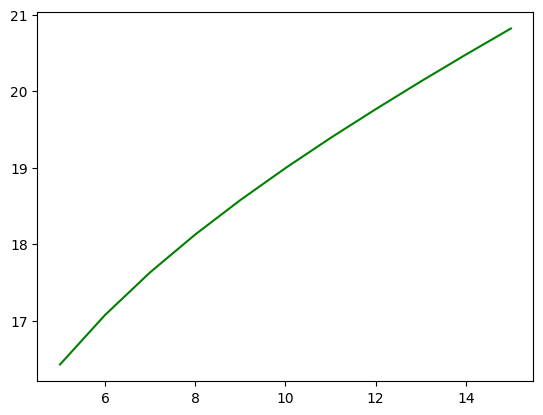

n_components with minimum perplexity: 5


In [107]:
import matplotlib.pyplot as plt

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1,
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter,
                                        topic_word_prior= topic_word_prior,
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(sentence_topics, start=5, end=15))

- 상기 나온 최저점의 혼잡도를 선정한다.
- 하지만 상기 그래프를 확인하면, 동일한 주제의 크롤링 데이타인 관계로 적정선의 혼잡도를 잡기 어려운 상황 - 5로 셋팅한다.

In [108]:
lda = LatentDirichletAllocation(n_components = 5,
                                max_iter=20,
                                topic_word_prior= 0.1,
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=7)

review_topics = lda.fit_transform(sentence_topics)
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: 가까이, 가봣습니, 가뜩이나, 가라사대, 가려움증, 가렵거, 가다가, 가능성, 가르침, 가부장
Topic #1: 가까이, 가라사대, 가려움증, 가다가, 가부장, 가르침, 가능성, 가봣습니, 가뜩이나, 가렵거
Topic #2: 가까이, 가라사대, 가렵거, 가려움증, 가르침, 가능성, 가봣습니, 가부장, 가뜩이나, 가다가
Topic #3: 가능성, 가봣습니, 가부장, 가다가, 가려움증, 가렵거, 가뜩이나, 가까이, 가라사대, 가르침
Topic #4: 가봣습니, 가르침, 가능성, 가라사대, 가다가, 가려움증, 가렵거, 가부장, 가까이, 가뜩이나


# 5.Gensim Topic Modeling

-Gensim은 Word2Vec으로 잘 알려져 있으며, 토픽 모델링을 비롯해 의미적인 자연어 처리를 위한 다양한 라이브러리를 제공한다.

In [109]:
!pip install --upgrade gensim

### 순서확인기

- Gensim은 먼저 토큰화 결과로부터 토큰과 gendim모듈이 내부적으로 사용하는 id를 매칭하는 사전을 생성 -> Dictionary 클래스 사용
- filter_extremes() 메소드에서, 사이킷런의 max_features에 해당하는 keep_n인수, min_df에 해당하는 no_below, max_df에 해당하는 no_above인수를 이용해 특성을 선택
- doc2bow()메소드로 토큰화된 결과를 카운트 벡터, 즉 BOW형태로 변환

- Gensim에서 LDA 모델을 수행하는 클래스인 LdaModel 시행
- num_topics : 토픽의 수
- id2word : Dictionary를 의미
- passes : 사이킷런의 max_iter와 같다고 보면 됨, 학습하는 횟수를 지정한다.


In [146]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(sentences_list_word)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in sentences_list_word]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 8283
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 1689


- Gensim에서 LDA 모델을 수행하는 클래스인 LdaModel 시행
- num_topics : 토픽의 수
- id2word : Dictionary를 의미
- passes : 사이킷런의 max_iter와 같다고 보면 됨, 학습하는 횟수를 지정한다.

In [147]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus,id2word=dictionary,passes=passes,num_topics=num_topics,random_state=7)

CPU times: user 7.32 s, sys: 124 ms, total: 7.45 s
Wall time: 7.43 s


In [148]:
model.print_topics(num_words=10)

[(0,
  '0.081*"치료" + 0.070*"증상" + 0.050*"완치" + 0.043*"정신" + 0.028*"적극" + 0.025*"상태" + 0.020*"신경증" + 0.018*"사실" + 0.016*"정신과" + 0.014*"정신분열증"'),
 (1,
  '0.028*"질문" + 0.017*"생각" + 0.017*"사람" + 0.016*"보험" + 0.014*"우울증" + 0.014*"지금" + 0.010*"가입" + 0.009*"친구" + 0.009*"상담" + 0.008*"치료"'),
 (2,
  '0.042*"심리치료" + 0.040*"약물" + 0.040*"원인" + 0.039*"마음" + 0.037*"치료" + 0.032*"문제" + 0.030*"우울증" + 0.025*"우울" + 0.022*"증상" + 0.021*"심리"'),
 (3,
  '0.032*"두통" + 0.018*"경우" + 0.017*"혈액" + 0.017*"증상" + 0.016*"순환" + 0.015*"사람" + 0.013*"운동" + 0.012*"통증" + 0.010*"효과" + 0.010*"머리"'),
 (4,
  '0.074*"증상" + 0.069*"치료" + 0.035*"정신" + 0.034*"심리" + 0.033*"완치" + 0.028*"신경증" + 0.026*"복용" + 0.026*"전문가" + 0.024*"적극" + 0.021*"검사"'),
 (5,
  '0.036*"치료" + 0.034*"상담" + 0.026*"우울증" + 0.020*"약물" + 0.017*"심리상담" + 0.013*"증상" + 0.012*"센터" + 0.011*"마음" + 0.011*"심리치료" + 0.011*"도움"'),
 (6,
  '0.032*"마음" + 0.023*"우울증" + 0.022*"생각" + 0.017*"자신" + 0.015*"증상" + 0.015*"치료" + 0.013*"사람" + 0.010*"인지" + 0.009*"불안" + 0.008*"질문"'),
 (7,
  '0.

- 숫자는 각 토픽으로 분류될 때 단어들의 기여도

- get_document_topics 메소드를 이용하면 인수로 넘긴 무너들에 대해 토픽 분포를 반환한다. 즉 인수로 corpus - BOW로 변환된 카운트 벡터를 요구하며, minimum_probability로 보여질 토픽의 비중에 대한 임계값을 설정할 수 있다.

In [149]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])

#topic distribution of the first document:  [(0, 0.0100023225), (1, 0.010004489), (2, 0.01000297), (3, 0.010003405), (4, 0.010002463), (5, 0.30072388), (6, 0.61924183), (7, 0.010006203), (8, 0.010006986), (9, 0.010005418)]


In [150]:
!pip install pyLDAvis

In [151]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

BrokenProcessPool: ignored

In [140]:
!pip install cloudpickle
!pip install --upgrade pandas

In [141]:
import cloudpickle

# Assuming you have a model to serialize
serialized_model = cloudpickle.dumps(model)

# Deserialize the model
deserialized_model = cloudpickle.loads(serialized_model)

# Use pyLDAvis with the deserialized model
lda_viz = gensimvis.prepare(model, corpus, dictionary, mds='mmds', R=30, sort_topics=False, n_jobs=1)

# Display the visualization
pyLDAvis.display(lda_viz)


TypeError: ignored

- 응집도를 구하는 방법

In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -7.035, coherence: -1.701


num_topics: 7, perplexity: -7.023, coherence: -1.735


num_topics: 8, perplexity: -7.023, coherence: -1.547


num_topics: 9, perplexity: -7.007, coherence: -1.891


num_topics: 10, perplexity: -6.996, coherence: -1.888


num_topics: 11, perplexity: -7.027, coherence: -2.164


num_topics: 12, perplexity: -7.019, coherence: -2.018


num_topics: 13, perplexity: -7.025, coherence: -2.255


num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


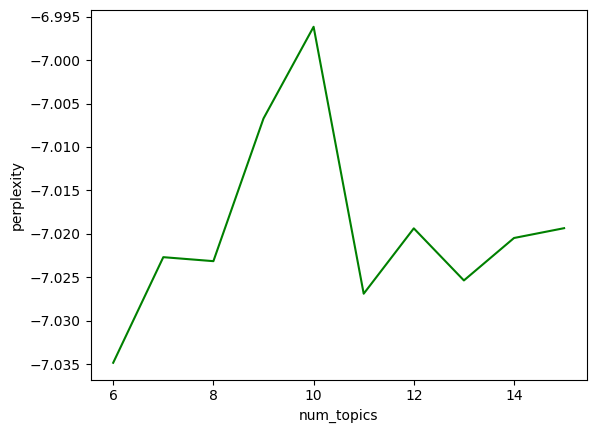

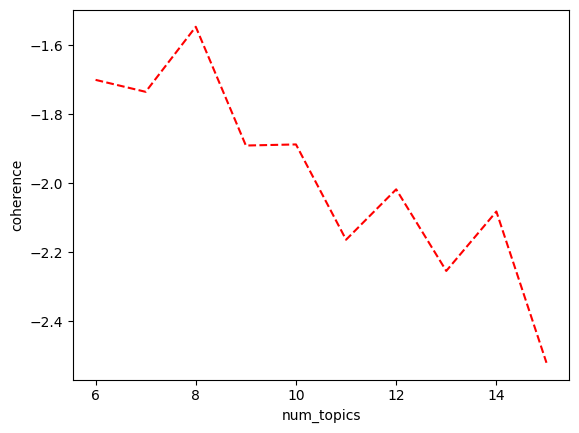

In [ ]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus,
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)